# Cleaning and EDA:

I'll start off by doing some cleaning to our data set and fixing any data type issues we may have. Then I'll conduct some exploratory data analysis to find trends/patterns in the data

In [1]:
import pandas as pd                                                                                                                                                                                                                                                                                                                                #importsimport pandas as %pdQ
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.gridspec as gridspec 
from scipy import stats
from sklearn.preprocessing import StandardScaler
from scipy.special import boxcox, inv_boxcox
from scipy.stats import boxcox as bx
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn import metrics
#options

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('chained_assignment', None)


In [2]:
#read in train data
train = pd.read_csv('./datasets/train.csv')
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
train.shape

(2051, 81)

In [4]:
#checking for null values

#thanks to Chanakya Vivek Kapoor on Kaggle for this solution 

def null_values(df):
    
    columns = df.isnull().sum().index
    values = df.isnull().sum().values
    null_percentage = []
    
    #finding null values in each column, dividing by shape of the data frame and multiplying by 100
    [null_percentage.append((df[column]).isnull().sum()/ df[column].shape[0] * 100) for column in columns]
    
    null_dict = {'Columns':columns, 'Null Values': values, 'Percentage of Null Values': null_percentage}
    
    null_table = pd.DataFrame(data = null_dict)
    
    return null_table

In [5]:
null_table = null_values(train)
null_table.sort_values(by = 'Percentage of Null Values', ascending = False).head()

,Columns,Null Values,Percentage of Null Values
73,Pool QC,2042,99.561190
75,Misc Feature,1986,96.830814
7,Alley,1911,93.174061
74,Fence,1651,80.497318
58,Fireplace Qu,1000,48.756704


In [6]:
def df(dataset):
    #remove columns with more than 90% of null values.
    dataset = dataset.loc[:, dataset.isin([np.nan]).mean() < .90]
    
    #fill in null values for columns with missing data that I want to keep
    dataset.fillna({'Fireplace Qu': 'NA', 'Fence': 'NA', 'Lot Frontage': 0}, inplace = True)
    
    #remaping ordinal columns to numerical values
    dataset['Exter Qual'] = dataset['Exter Qual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA': 0})
    dataset['Exter Cond'] = dataset['Exter Cond'].map({'Ex':5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, 'NA': 0})
    dataset['Bsmt Qual']= dataset['Bsmt Qual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA': 0})
    dataset['Bsmt Cond'] =dataset['Bsmt Cond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1, 'NA': 0})
    dataset['Bsmt Exposure'] = dataset['Bsmt Exposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No':1, 'NA': 0})
    dataset['BsmtFin Type 1'] = dataset['BsmtFin Type 1'].map({'GLQ': 6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 
                                                               'Unf':1, 'NA':0})
    dataset['BsmtFin Type 2'] = dataset['BsmtFin Type 2'].map({'GLQ': 6, 'ALQ':5, 'BLQ': 4, 'Rec':3, 'LwQ':2,
                                                               'Unf':1, 'NA':0})
    dataset['Heating QC'] = dataset['Heating QC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1})
    dataset['Electrical'] = dataset['Electrical'].map({'SBrkr':4, 'FuseA':3, "FuseF":2, 'FuseP':1, 'Mix':0})
    dataset['Kitchen Qual']= dataset['Kitchen Qual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
    dataset['Functional']= dataset['Functional'].map({'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 
                                                      'Sev':1, 'Sal':0 })
    dataset['Fireplace Qu'] = dataset['Fireplace Qu'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0})
    dataset['Garage Finish'] = dataset['Garage Finish'].map({'Fin':3, 'RFn':2, 'Unf':1, 'NA':0 })
    dataset['Garage Qual'] =dataset['Garage Qual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0})
    dataset['Garage Cond']= dataset['Garage Cond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0})
    dataset['Paved Drive']= dataset['Paved Drive'].map({'Y':3, 'P':2, 'N':1})
    dataset['Fence']= dataset['Fence'].map({'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'NA':0})
    
    #changing numeric data types to strings(object)
    dataset['Mo Sold'] = dataset['Mo Sold'].astype(str)
    dataset['Yr Sold'] = dataset['Yr Sold'].astype(str)
    dataset['MS SubClass'] = dataset['MS SubClass'].astype(str)
    #
#     #dummify left over categorical data columns
#     train_data = pd.get_dummies(data = train_data, columns = list(train_data.select_dtypes(['object']).columns), drop_first=True)
    
    #drop rest of null values less than 90%
    dataset.dropna(inplace=True)
    
    return dataset

## Dealing with missing values:

From our results above, 5 of our columns have about or over 50% of it's data missing.

It's important to note that a column having null values could mean that data was not recorded or does not exist(ie: NA in the 'Pool QC' column means the property has no pool) so it can still be valuable information.

For the purposes of this regression model, I will get rid of columns that contain more than 90% of null data which will be the **'Pool QC', 'Alley' and 'Misc Feature' columns**. It would mean that data is truly missing or these properties do not contain a misc feature, a pool or an alley which is not helping much from an analysis point of view.

## Ordinal and Nominal data:
Some of our data contains values that are ordinal, meaning that the values have some intrinsic order. This means they can be ranked from best to worst or numerically (from 1-5 for example). Converting our ordinal data columns would be best in order to assess their impact on the model I will create.
Nominal values have no intrinsic order and are typically descriptive. We will convert these to dummy columns later on.

## Data types:
In addition to changing our ordinal data to numeric columns, I've also changed some of our numeric columns to strings. **'Mo Sold', 'Year Sold', and 'MS Subclass'** are currently numeric but should be more of a string as they are descriptive. Our model might confuse the values and assume a higher value should be weighted more.  

In [7]:
train_data = df(train)

In [8]:
train_data.shape

(1866, 78)

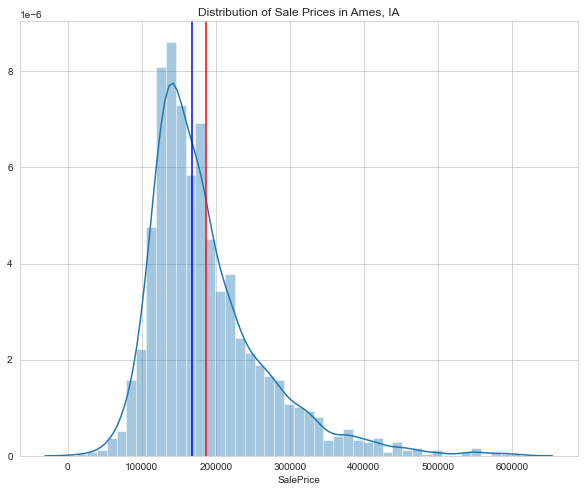

In [9]:
#checking distribution of our Sale Price data
plt.figure(figsize=(10,8))
sns.distplot(train_data.loc[:, 'SalePrice'], norm_hist = True,)
plt.axvline(x = train_data['SalePrice'].mean(), c = 'red')
plt.axvline(x = train_data['SalePrice'].median(), c = 'blue')
plt.title('Distribution of Sale Prices in Ames, IA');

## Distribution of Sale Price
Our housing price data seems to be slightly right skewed to normal but not exactly a bell shaped curve, meaning that our mean(red line) is higher than the median(blue line). This could be because we have homes that tend to be higher priced thereby offsetting our data. We will need to correct for outliers in order to normalize our data.

To fix this issue, I'll apply a log transformation to the Sale Price data and correct the skew.

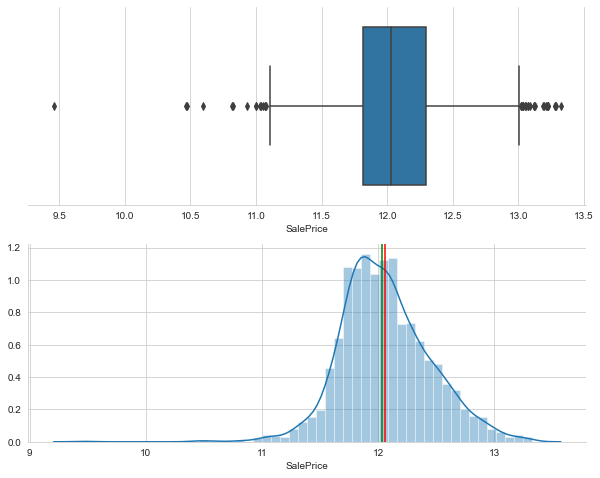

In [10]:
x = np.log1p(train_data['SalePrice'])
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(10,8))

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)
plt.axvline(x = x.mean(), c = 'red')
plt.axvline(x = x.median(), c = 'green')

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.show()

My data is now more left skewed as it has a longer left tail but the still follows a normal distribution. This could be because we have a larger mean value. Nonetheless our Sale Price has now been normalized by performing a log transformation. 

## Correlation to Sale Price
Let's examine which independent variables are the most correlated to our target variable.

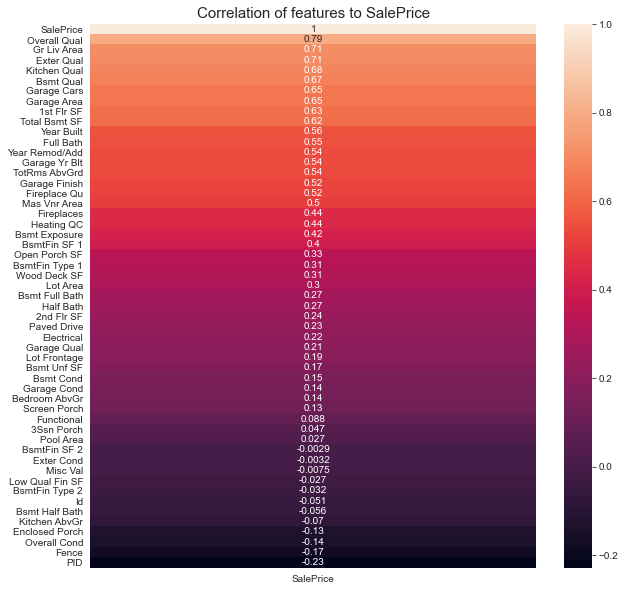

In [11]:
corr = train_data.corr()['SalePrice'].sort_values(ascending = False).to_frame()
plt.figure(figsize=(10,10))
plt.title('Correlation of features to SalePrice', fontsize = 15)
sns.heatmap(corr, annot = True,linecolor='black');

According to the heatmap, the top 5 values most correlated with price are as follows:
- Overall Qual
- Gr Liv Area
- Exter Qual
- Kitchen Qual
- Bsmt Qual

## Visualizing variables highly correlated with Sale Price

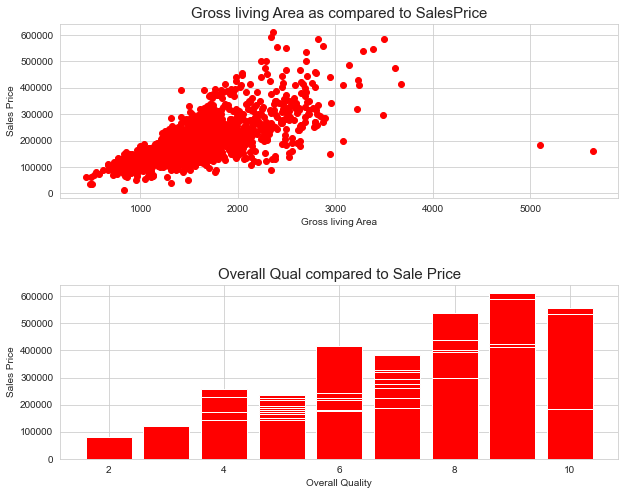

In [12]:
fig, axs = plt.subplots(2,figsize = (10,8))
fig.subplots_adjust(hspace = 0.5)
axs[0].scatter(x = train_data['Gr Liv Area'], y = train_data['SalePrice'], c = 'red')
axs[0].set_title('Gross living Area as compared to SalesPrice', fontsize = 15)
axs[0].set_xlabel("Gross living Area")
axs[0].set_ylabel('Sales Price')

x = train_data['Overall Qual']
y = train_data['SalePrice']
axs[1].bar(x, y, color = 'red')
axs[1].set_title('Overall Qual compared to Sale Price', fontsize = 15)
axs[1].set_xlabel('Overall Quality')
axs[1].set_ylabel('Sales Price');

In [13]:
#dropping outliers from Gross living area
train_data.loc[train_data['Gr Liv Area'] > 4000]
train_data.drop(labels=[960, 1885], inplace=True)
train_data.shape

(1864, 78)

## Multi Collinearity
- What is Multi Collinearity?
    - It is when multiple independent variables can predict each other, hence making it difficult for the regression model to know which variables are directly impacting the target variable the most.

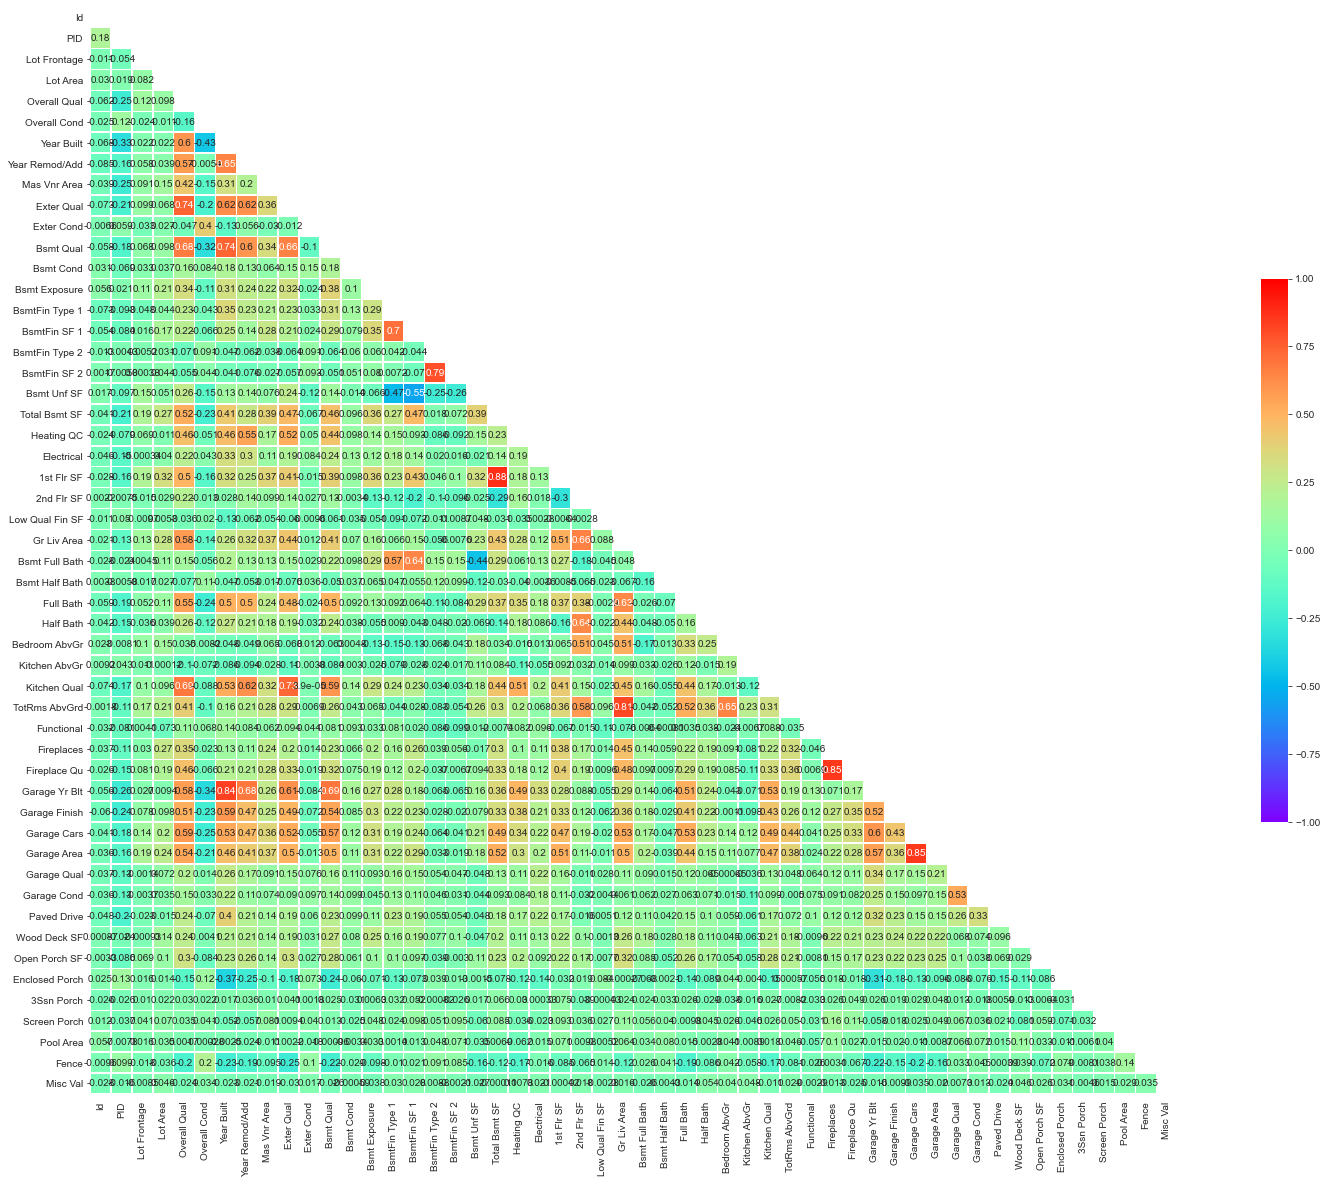

In [14]:
# searching for multicolinarity in each numerical variable

#Tweaking diagonal correlation example from seaborn.pydata.org

#correlation dataframe of independent variables only
new_corr = train_data.drop(columns='SalePrice')
corr = new_corr.corr()
#generate mask for uper triangle
masked_corr = np.triu(np.ones_like(corr, dtype = bool))
#mtplotlib figure
fig, ax = plt.subplots(figsize = (30,20))
#color map
cmap = sns.diverging_palette(230, 30, as_cmap=True)

#draw heatmap
sns.heatmap(corr,mask= masked_corr, vmin= -1,vmax= 1, center= 0, annot=True, cmap= 'rainbow',
           square= True, linewidths= .5, cbar_kws={"shrink": .5}); 

Even though the heatmap is a little busy, I can see that a few of our independent variables are highly correlated with each other. I'll examining the variables in **RED** as that signifies the highest correlation(i.e: .75 and above).Let's take a closer look at some of those variables.

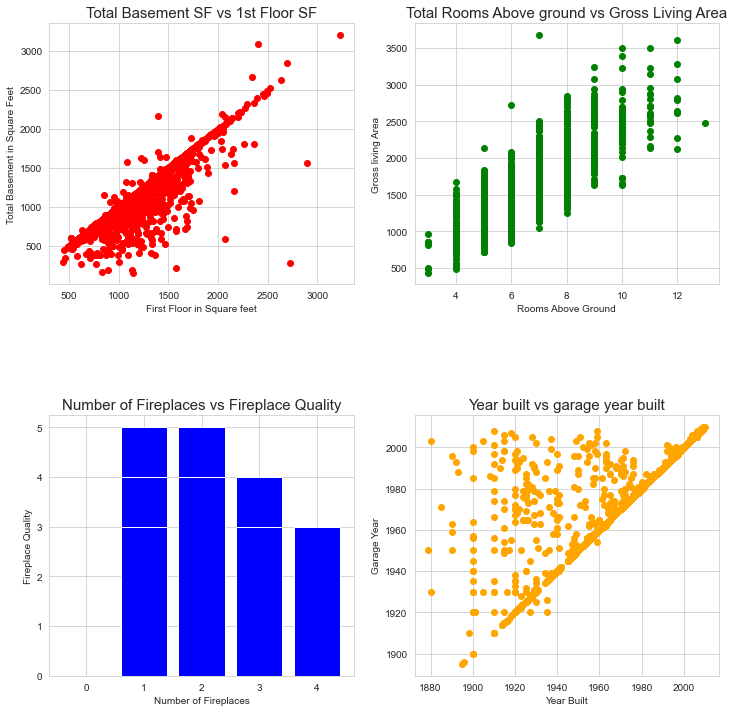

In [15]:
#Creating visuals for variables that are higly correlated
fig, axs = plt.subplots(2,2,figsize = (12,12))
fig.subplots_adjust(hspace = 0.5)
axs[0,0].scatter(x = train_data['1st Flr SF'], y = train_data['Total Bsmt SF'], c = 'red')
axs[0,0].set_title('Total Basement SF vs 1st Floor SF', fontsize= 15)
axs[0,0].set_xlabel("First Floor in Square feet")
axs[0,0].set_ylabel('Total Basement in Square Feet')

axs[0,1].scatter(x = train_data['TotRms AbvGrd'], y = train_data['Gr Liv Area'], c = 'green')
axs[0,1].set_title('Total Rooms Above ground vs Gross Living Area', fontsize = 15)
axs[0,1].set_xlabel("Rooms Above Ground")
axs[0,1].set_ylabel('Gross living Area')

x = train_data['Fireplaces']
y = train_data['Fireplace Qu']
axs[1,0].bar(x, y, color = 'blue')
axs[1,0].set_title('Number of Fireplaces vs Fireplace Quality', fontsize = 15)
axs[1,0].set_xlabel("Number of Fireplaces")
axs[1,0].set_ylabel('Fireplace Quality')

axs[1,1].scatter(x = train_data['Year Built'], y = train_data['Garage Yr Blt'], c = 'orange')
axs[1,1].set_title('Year built vs garage year built', fontsize = 15)
axs[1,1].set_xlabel("Year Built")
axs[1,1].set_ylabel('Garage Year');

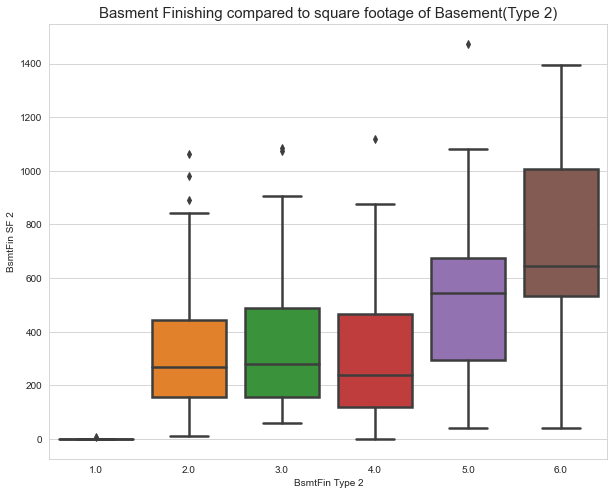

In [16]:
plt.figure(figsize=(10,8))
plt.title('Basment Finishing compared to square footage of Basement(Type 2)', fontsize =15)
sns.boxplot(x = train_data['BsmtFin Type 2'], y = train_data['BsmtFin SF 2'], linewidth= 2.5);

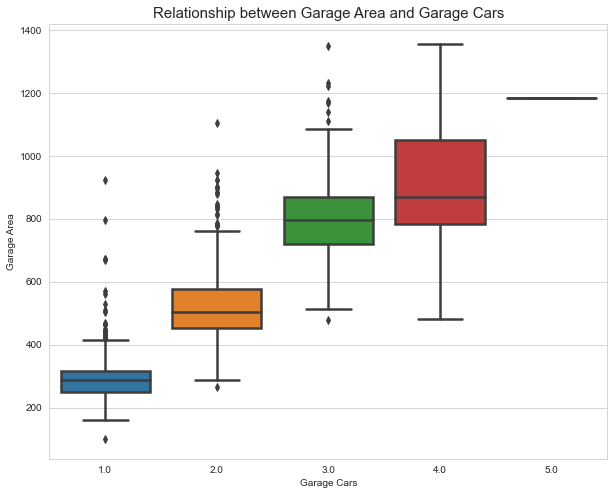

In [17]:
plt.figure(figsize=(10,8))
plt.title('Relationship between Garage Area and Garage Cars', fontsize = 15)
sns.boxplot(x = train_data['Garage Cars'], y = train_data['Garage Area'],linewidth= 2.5);

## Observations of multi collinearity
- With the exception of a few outliers, these variables are highly correlated to each other. As one variable goes up, so does the other or vice versa, as is the case with fireplace quality and number of fireplaces. 

- *Total Basement SF vs first floor SF*
    - This shows a linear relationship with the exception of a few outliers. This means that how large the 1st floor is is directly correlated with the size of the basement 
    
- *Total Rooms Above grade vs Gross living area*
    - Also showcases an upward trending relationship. The number of rooms in a home(not including bathrooms) is directly related to the gross living area, which isn't much of a surprise.

- *Fireplace Quality vs Number of fireplaces*
    - At first we see an increasing linear relationship between the two variables. As the number of fireplaces increases however, there is a decline in it's quality which shows an inverse relationship.
    
- *Year Built vs Garage Year built*
    - Now, we see an almost perfectly linear relationship. The diagram does show that there are garages that were built years later after the home was.

- *Basement Finishing (Type 2) vs Basment SF (Type 2)*
    - There's is a gradual trend upwards trend with this relationship. As the Finishing quality increases, so does the square footage, which implies that the quality of the basement living quarters is directly related to how large the basement is.
    
- Garage Cars vs Garage Area:
    - Also witnessing an upwards trend. The more car garages we have the bigger the garage area. however, after 4 car garages there's diminishing returns.
    

## What does this mean?
- Collinearity is a big issue for a regression model because it doesn't allow us to accurately pinpoint which independent variable has the most effect on the dependent. Instead, one independent variable predicts the other thereby leaving us with duplicate results which reduces the accuracy of our model. For this project, I will feature engineer a few of those variables to reduce multi collinearity.

## Feature engineering:

In this section, I'll be creating new features that can fix our multi collinear variables by using raw data we already have.

In [18]:
#making copy of train dataset
new_train = train_data.copy()

In [19]:
#creating new features using raw data
new_train['Has Bsmt'] = new_train['Total Bsmt SF'].apply(lambda x :1 if x > 0 else 0 )
new_train['Has Pool'] = new_train['Pool Area'].apply(lambda x : 1 if x > 0 else 0)
new_train['Has Garage'] = new_train['Garage Cars'].apply(lambda x: 1 if x > 0 else 0)
new_train['Has Fireplace'] = new_train['Fireplaces'].apply(lambda x :1 if x > 0 else 0)
new_train['Has 2ndFlr'] = new_train['2nd Flr SF'].apply(lambda x: 1 if x > 0 else 0)
new_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Has Bsmt,Has Pool,Has Garage,Has Fireplace,Has 2ndFlr
0,109,533352170,60,RL,0.0,13517,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,4,3,CBlock,3.0,3.0,1.0,6.0,533.0,1.0,0.0,192.0,725.0,GasA,5,Y,4,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,7,0,0,Attchd,1976.0,2.0,2.0,475.0,3.0,3.0,3,0,44,0,0,0,0,0,0,3,2010,WD,130500,1,0,1,0,1
1,544,531379050,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,4,3,PConc,4.0,3.0,1.0,6.0,637.0,1.0,0.0,276.0,913.0,GasA,5,Y,4,913,1209,0,2122,1.0,0.0,2,1,4,1,4,8,7,1,3,Attchd,1997.0,2.0,2.0,559.0,3.0,3.0,3,0,74,0,0,0,0,0,0,4,2009,WD,220000,1,0,1,1,1
2,153,535304180,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,4,CBlock,3.0,3.0,1.0,6.0,731.0,1.0,0.0,326.0,1057.0,GasA,3,Y,4,1057,0,0,1057,1.0,0.0,1,0,3,1,4,5,7,0,0,Detchd,1953.0,1.0,1.0,246.0,3.0,3.0,3,0,52,0,0,0,0,0,0,1,2010,WD,109000,1,0,1,0,0
3,318,916386060,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4.0,3.0,1.0,1.0,0.0,1.0,0.0,384.0,384.0,GasA,4,Y,4,744,700,0,1444,0.0,0.0,2,1,3,1,3,7,7,0,0,BuiltIn,2007.0,3.0,2.0,400.0,3.0,3.0,3,100,0,0,0,0,0,0,0,4,2010,WD,174000,1,0,1,0,1
4,255,906425045,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,3,3,PConc,2.0,4.0,1.0,1.0,0.0,1.0,0.0,676.0,676.0,GasA,3,Y,4,831,614,0,1445,0.0,0.0,2,0,3,1,3,6,7,0,0,Detchd,1957.0,1.0,2.0,484.0,3.0,3.0,1,0,59,0,0,0,0,0,0,3,2010,WD,138500,1,0,1,0,1


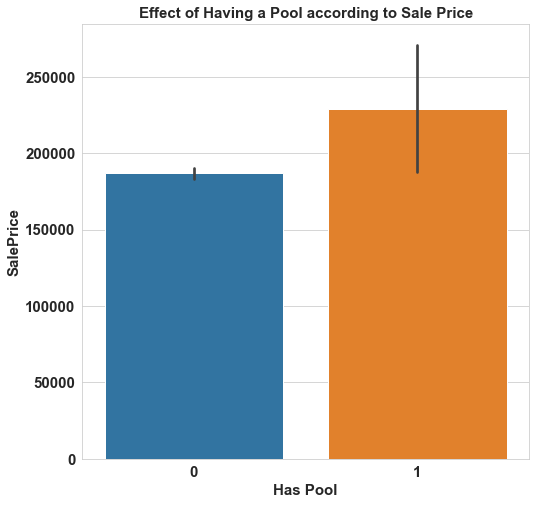

In [20]:
plt.figure(figsize=(8,8))
plt.title('Effect of Having a Pool according to Sale Price', fontsize = 15, weight = 'bold')
sns.barplot(data = new_train, x = 'Has Pool', y= 'SalePrice')
plt.xticks(weight = 'bold', fontsize = 15)
plt.yticks(weight= 'bold', fontsize = 15)
plt.xlabel('Has Pool', fontsize = 15, weight = 'bold')
plt.ylabel('SalePrice',fontsize = 15, weight = 'bold');

Having a pool significantly increases Saleprice. On average, sellers can expect at least $50,000 more in Sale price if their home includes a pool, holding all other values constant.

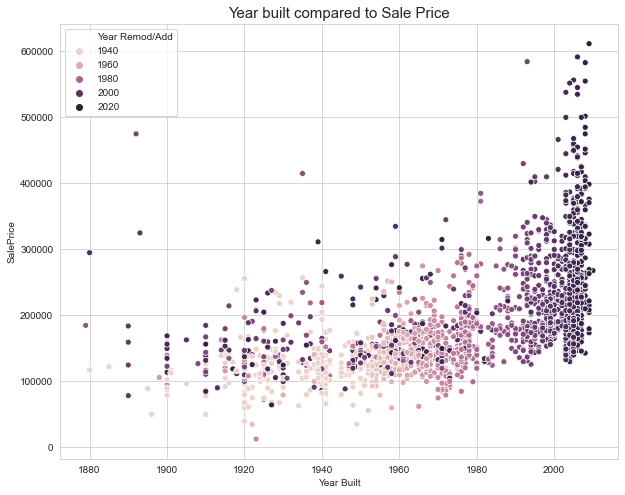

In [21]:
plt.figure(figsize=(10,8))
plt.title('Year built compared to Sale Price', fontsize = 15)
sns.scatterplot(data = new_train, x = 'Year Built', y = 'SalePrice', hue = new_train['Year Remod/Add']);

This visual shows that homes built and or remodeled in later years (especially after 2000) command the highest price in this market.

## More Exploratory Analysis

In [22]:
def visuals(data, x, y, palette):
    plt.figure(figsize=(15,10))
    plt.title(f'Relationship between {x} and {y}', fontsize = 15) 
    sns.barplot(data = data, x = x, y= y, palette= palette)
    plt.xticks(fontsize = 7)
    sns.despine(left=True, bottom = True)
    return visuals

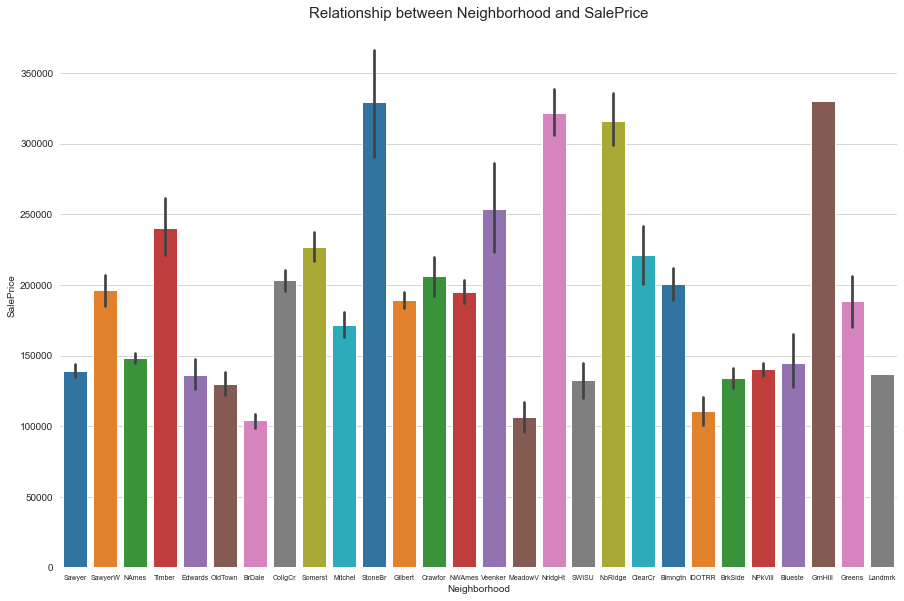

In [23]:
visuals(new_train, 'Neighborhood', 'SalePrice', palette='tab10');

The most expensive neighborhood in Ames, IA is StoneBr. Sellers living in this neighborhood can expect a higher sale price for their homes than any other neighborhood, holding all other factors constant that is 

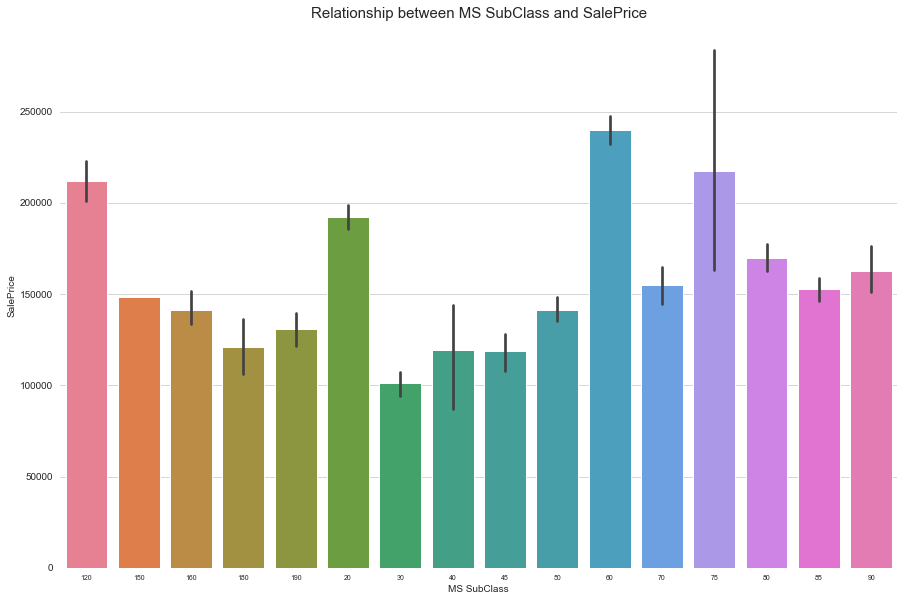

In [24]:
visuals(new_train, 'MS SubClass', 'SalePrice', 'husl');

As listed in the county files, an MS Sub class identifies the dwelling type of the home. An MS Sub Class of 75 means that the house is a 2 1/2 story structure. This would mean that the most expenisve homes in Ames, IA tend to be the 2 1/2 story houses, signifying that the town is oriented more towards families.

In [25]:
new_train.loc[:].head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Has Bsmt,Has Pool,Has Garage,Has Fireplace,Has 2ndFlr
0,109,533352170,60,RL,0.0,13517,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,4,3,CBlock,3.0,3.0,1.0,6.0,533.0,1.0,0.0,192.0,725.0,GasA,5,Y,4,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,7,0,0,Attchd,1976.0,2.0,2.0,475.0,3.0,3.0,3,0,44,0,0,0,0,0,0,3,2010,WD,130500,1,0,1,0,1
1,544,531379050,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,4,3,PConc,4.0,3.0,1.0,6.0,637.0,1.0,0.0,276.0,913.0,GasA,5,Y,4,913,1209,0,2122,1.0,0.0,2,1,4,1,4,8,7,1,3,Attchd,1997.0,2.0,2.0,559.0,3.0,3.0,3,0,74,0,0,0,0,0,0,4,2009,WD,220000,1,0,1,1,1
2,153,535304180,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,4,CBlock,3.0,3.0,1.0,6.0,731.0,1.0,0.0,326.0,1057.0,GasA,3,Y,4,1057,0,0,1057,1.0,0.0,1,0,3,1,4,5,7,0,0,Detchd,1953.0,1.0,1.0,246.0,3.0,3.0,3,0,52,0,0,0,0,0,0,1,2010,WD,109000,1,0,1,0,0
3,318,916386060,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4.0,3.0,1.0,1.0,0.0,1.0,0.0,384.0,384.0,GasA,4,Y,4,744,700,0,1444,0.0,0.0,2,1,3,1,3,7,7,0,0,BuiltIn,2007.0,3.0,2.0,400.0,3.0,3.0,3,100,0,0,0,0,0,0,0,4,2010,WD,174000,1,0,1,0,1
4,255,906425045,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,3,3,PConc,2.0,4.0,1.0,1.0,0.0,1.0,0.0,676.0,676.0,GasA,3,Y,4,831,614,0,1445,0.0,0.0,2,0,3,1,3,6,7,0,0,Detchd,1957.0,1.0,2.0,484.0,3.0,3.0,1,0,59,0,0,0,0,0,0,3,2010,WD,138500,1,0,1,0,1


## Line Assumptions:

In this section I'll check to make sure our data adheres to the 'Line' Assumptions which are:

- Linear relationship between dependent and independent variables
- Independence of variables (No multi colinearity)
- Equality of variances (Homoscedacity)
- Normality: residuals of model are normally distributed

In [26]:
#credit to Chanya from Kaggle here

def three_chart_plot(df, feature):
    fig = plt.figure(figsize = (12, 10))
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig, wspace=0.5, hspace= 0.5)
    
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    
    sns.distplot(df.loc[:, feature], norm_hist = True, ax = ax1)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')
    
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:,feature], orient = 'v', ax = ax3 )


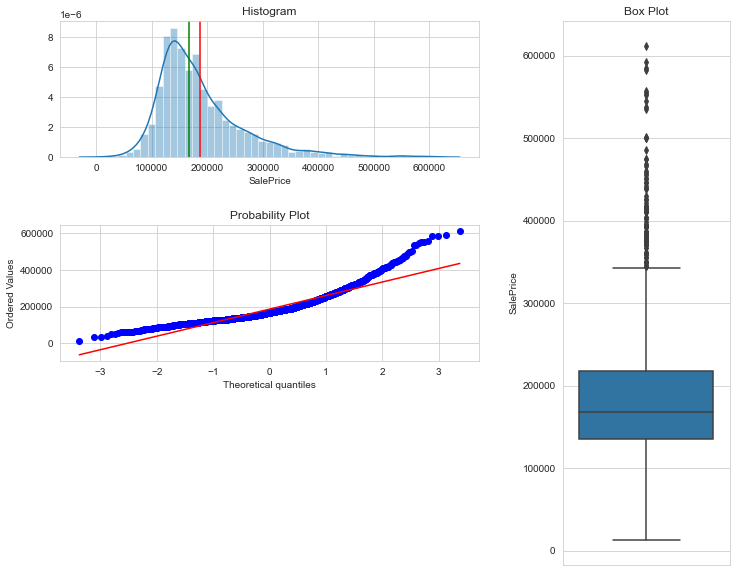

In [27]:
three_chart_plot(new_train, 'SalePrice')

From the plot above, we can see that our data does not follow a normal distribution which violates of  the **LINE** assumptions. 
A major observervation here, our distribution plot has a very long right tail signifying a right skewed distribution.This means that there are homes in the area that are priced far above the mean. The box plot also showcases lots of outliers past the \\$350,000 sale price mark. Why could that be? What about these homes contribute to such a jump in Sale price? Let's explore further.

In [28]:
pricey_homes = new_train.loc[new_train['SalePrice'] >= 350000]
pricey_homes.head()
pricey_homes.shape

(84, 83)

In [29]:
less_pricey = new_train.loc[new_train['SalePrice'] <= 350000]
less_pricey.shape

(1784, 83)

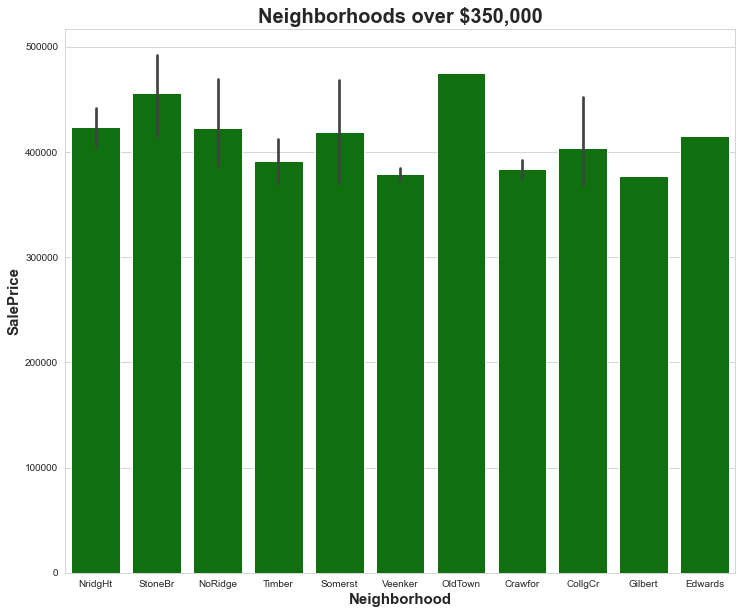

In [30]:
#examining the neighborhoods
plt.figure(figsize=(12,10))
plt.title('Neighborhoods over $350,000', fontsize = 20, weight = 'bold')
sns.barplot(x = pricey_homes['Neighborhood'], y = pricey_homes['SalePrice'], color = 'Green')
plt.xlabel('Neighborhood', fontsize= 15, weight = 'bold')
plt.ylabel('SalePrice', fontsize = 15, weight = 'bold')
plt.xticks(fontsize = 10);

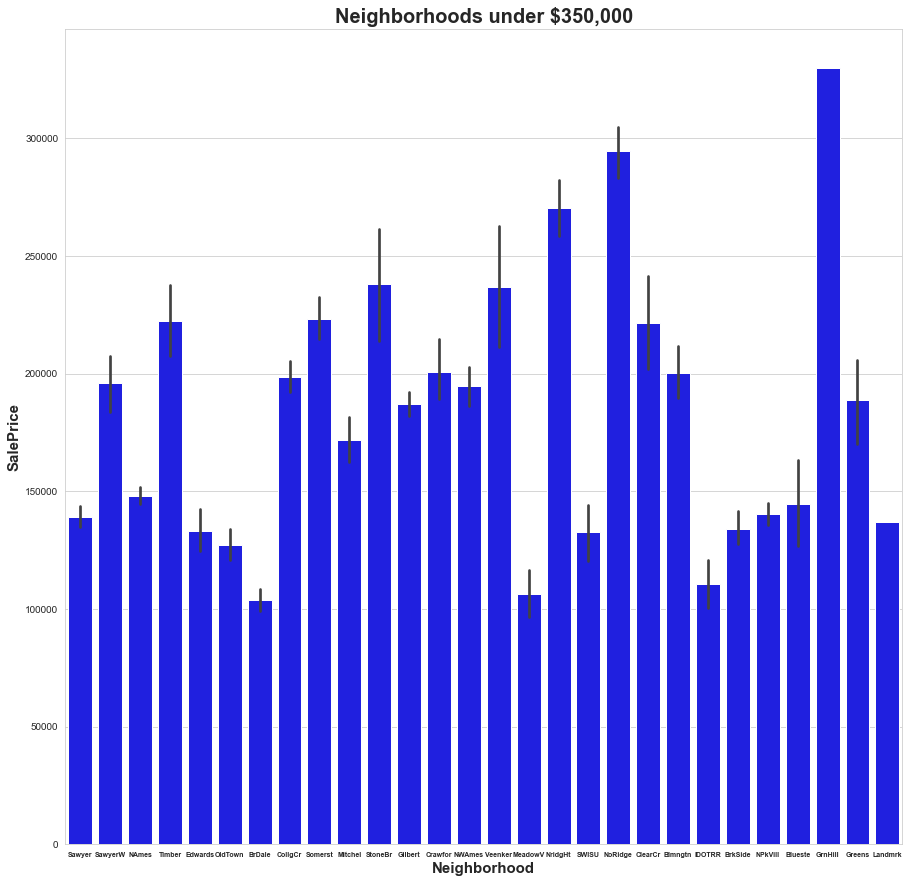

In [31]:
less_pricey = new_train.loc[new_train['SalePrice'] <= 350000]
plt.figure(figsize=(15,15))
plt.title('Neighborhoods under $350,000', fontsize = 20, weight = 'bold')
sns.barplot(x = less_pricey['Neighborhood'], y = less_pricey['SalePrice'], color = 'blue')
plt.xlabel('Neighborhood', fontsize = 15, weight = 'bold')
plt.ylabel('SalePrice', fontsize = 15, weight = 'bold')
plt.xticks(fontsize = 7, weight = 'bold');


In our first bar chat examining the Sales price to Neighborhood, **StoneBr** emerged as the most expensive. While looking at the **pricey_homes** data this seems to be true, as it narrowly edges out **OldTown** neighborhood as the most expensive. However, with further analysis, we see that it happens to be a few homes in that neighborhood that are driving up this price.When evaluating the same neighborhood in the **less_pricey** data, we see an average price just over the \\$250,000 mark 

Another example is the 'OldTown' neighborhood which apprears to have a few homes over the \\$350000 price range but when we examine the **less_pricey** data, we see that most homes in that neighborhood have an average sale price less than \\$150000

This could signify that we have different markets in the same towns!From these two graphs we can see that there's a reason for the high increase in price and it is not random errors. 

In [32]:
def compare_plots(data, column, plot_title, color):
    #creates bar plots and expresses the values as percentages
    
    fig, ax = plt.subplots(1, 1, figsize = (10,8))
    
    the_count = data[column].value_counts().sort_values(ascending = False).reset_index()
    the_count['percentage'] = round(the_count[column]/data.shape[0] * 100, 2)
    
    ax.barh(the_count.iloc[:, 0], the_count.iloc[:, 2], edgecolor = 'grey', color = sns.color_palette(color, len(the_count)))
    
    ax.invert_yaxis()
    #remove spines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    #show top values first
    ax.invert_yaxis()
    
    ax.grid(b=None, color='grey', linestyle='--', linewidth=1, alpha=0.2)
    
    #set title
    ax.set_title(label = plot_title, weight = 'bold', fontsize = 20)
    
    #set x and y labels
    ax.set_xlabel(f'{column} expressed as percentages', weight = 'bold', fontsize = 15)
    ax.set_ylabel(column, weight = 'bold', fontsize =15)
    
    #input percentages
    for i in ax.patches:
        ax.text(i.get_width() + 0.5, i.get_y() + 0.5, str(round((i.get_width()), 2)),
                fontsize=10, fontweight='bold', color='black')
        
    #renumber y_ticks
    plt.yticks(weight = 'bold')
    plt.xticks(weight = 'bold')
    
    return compare_plots;

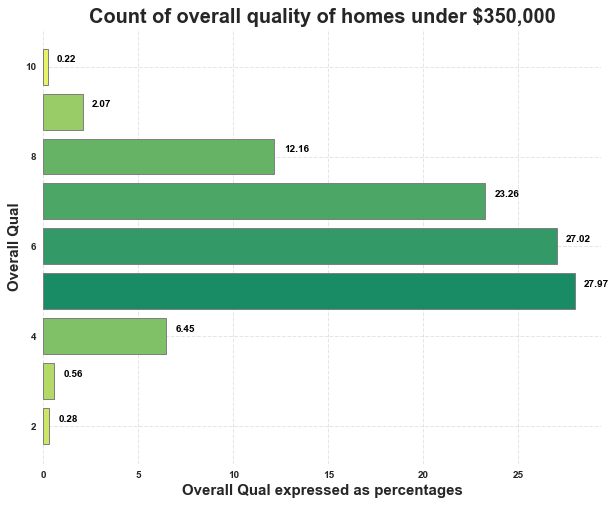

In [33]:
compare_plots(less_pricey, 'Overall Qual', 'Count of overall quality of homes under $350,000', 'summer');

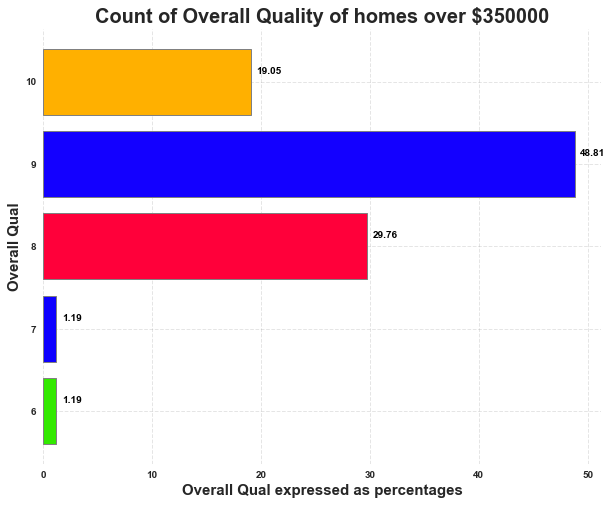

In [34]:
compare_plots(pricey_homes, 'Overall Qual', 'Count of Overall Quality of homes over $350000', 'prism_r');

Judging from the bar plots above, there is a clear difference between homes priced below and above \\$350,000. 

On average, 48.81% of homes over \\$350,000 or almost half of the dataset
have an overall quality score of 9 and above compared to 2.07% of homes under $350,000 having the same quality.

This signifies that homes above \\$350000 are of better overall quality, even with the pricier homes having less data than the lower priced homes.

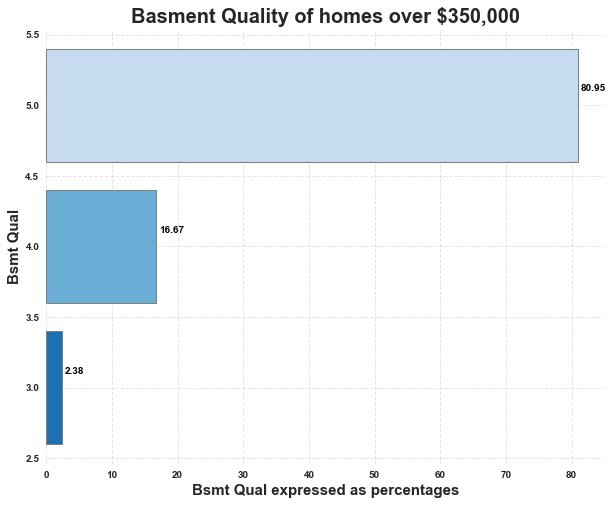

In [35]:
compare_plots(pricey_homes, 'Bsmt Qual', 'Basment Quality of homes over $350,000', 'Blues');

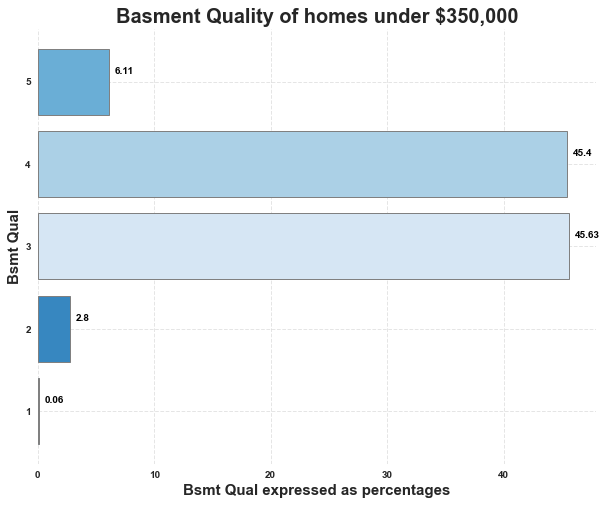

In [36]:
compare_plots(less_pricey, 'Bsmt Qual', 'Basment Quality of homes under $350,000', 'Blues');

80.95% of homes priced over \\$350,000 have a best basment quality rating of 5, the highest rating according to our scale. Compared to 6.11% of homes under \\$350,000 having a rating of 5, we can say that most homes priced above $350000 have the best quality of basements.

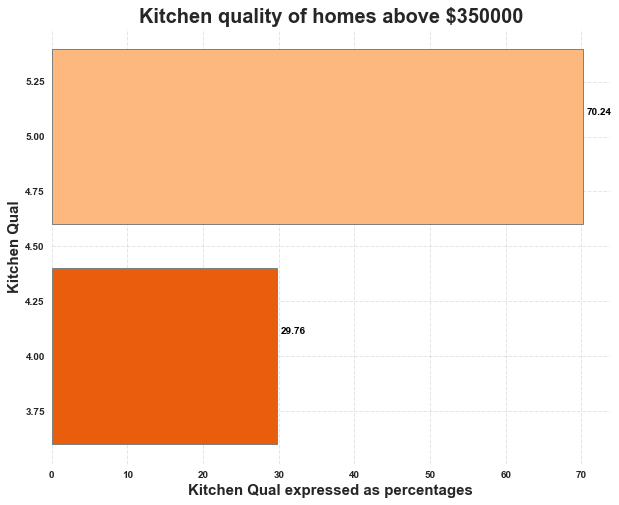

In [37]:
compare_plots(pricey_homes, 'Kitchen Qual', "Kitchen quality of homes above $350000", 'Oranges');

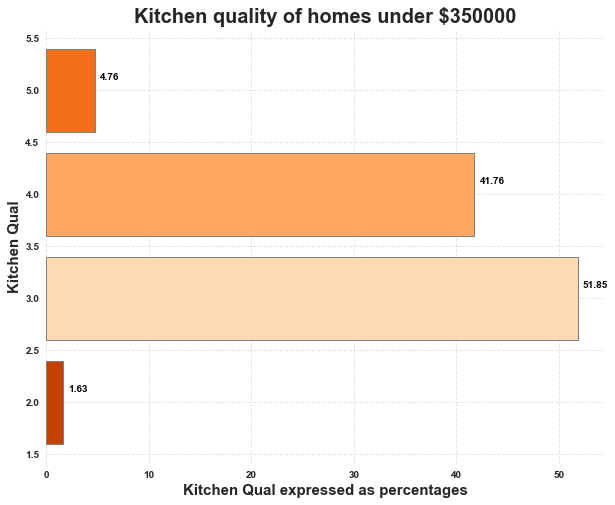

In [38]:
compare_plots(less_pricey, 'Kitchen Qual', "Kitchen quality of homes under $350000", 'Oranges');

Homes over \\$350,000 have a greater kitchen quality compared to homes under this price range.

## Final Evaluation:

As we can see through our graphs, the outliers in the original 'SalePrice' box plot are not simply random occurances; they showcase a real trend in telling us why these homes have a greater price range than others.

# Modeling:

## Transforming SalePrice variable using a log transformation.

- First we will figure out how skewed our data is and transform if need be so if follows a normal distribution.

In [39]:
trained = new_train.copy()
trained['SalePrice'].agg(['skew', 'kurtosis']).transpose()

skew        1.612462
kurtosis    3.677343
Name: SalePrice, dtype: float64

- Since our data is highly skewed, we will transform it using the log method below

In [40]:
trained = pd.get_dummies(data = trained, drop_first=True)
trained.shape

(1864, 219)

In [41]:
trained.insert(len(trained.columns), 'log Sale Price',
              np.log1p(trained['SalePrice']))

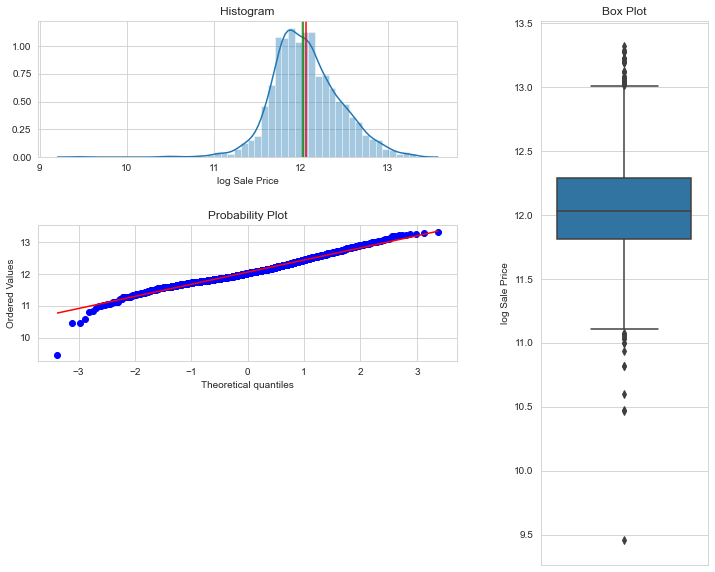

In [42]:
three_chart_plot(trained, 'log Sale Price')

In [43]:
trained['log Sale Price'].agg(['skew', 'kurtosis']).transpose()

skew        0.087901
kurtosis    1.580504
Name: log Sale Price, dtype: float64

Our Skew is much better! Our data is now moderately skewed but the goal is to get it to be fairly symmetrical. One of our data points seems to be an extreme outlier. Let's investigate further

In [44]:
trained.loc[trained['log Sale Price'] < 11]

,Id,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,SalePrice,Has Bsmt,Has Pool,Has Garage,Has Fireplace,Has 2ndFlr,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS Zoning_FV,MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_NoSeWa,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Mod,Land Slope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,Heating_GasW,Heating_Grav,Heating_OthW,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Mo Sold_10,Mo Sold_11,Mo Sold_12,Mo Sold_2,Mo Sold_3,Mo Sold_4,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,log Sale Price
408,1556,911102170,50.0,8500,4,4,1920,1950,0.0,3,2,3.0,3.0,1.0,1.0,0.0,1.0,0.0,649.0,649.0,3,4,649,668,0,1317,0.0,0.0,1,0,3,1,3,6,7,0,0,1920.0,1.0,1.0,250.0,3.0,2.0,1,0,54,172,0,0,0,3,0,40000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0

Data entry 1628 shows a Sale Price of $12,789. Although the overall condition and exterior are poor, there may be other factors indicating why this home is priced so low. There are other homes with lesser quality and living area but they are still priced higher. We may not have enough information to figure out why this price is so low and hence it could affect our model. I will drop this outlier for now

In [45]:
trained.drop(index=1628, inplace = True)
trained.shape

(1863, 220)

In [46]:
trained['log Sale Price'].agg(['skew', 'kurtosis']).transpose()

skew        0.252125
kurtosis    0.629153
Name: log Sale Price, dtype: float64

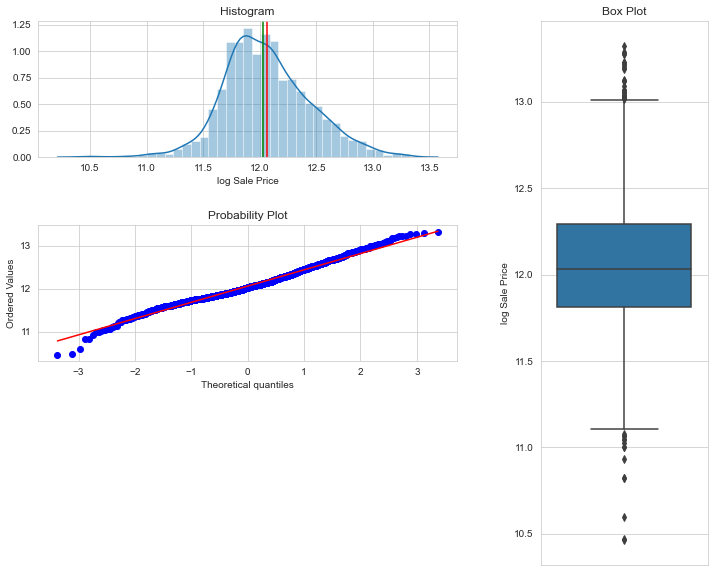

In [47]:
three_chart_plot(trained, 'log Sale Price')

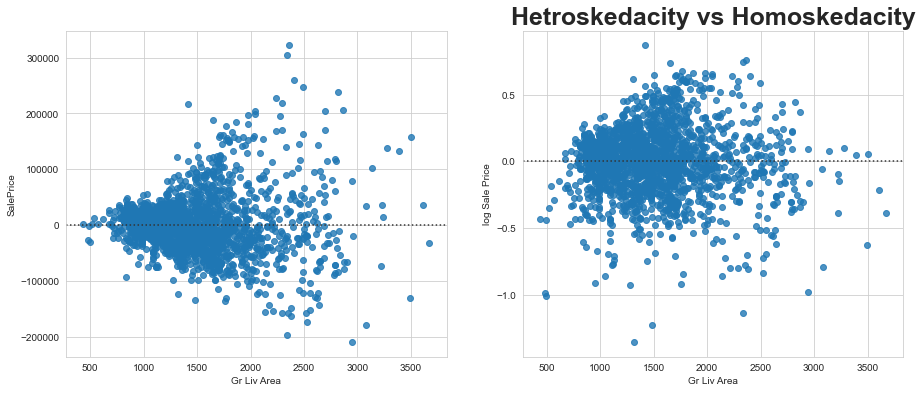

In [61]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6),
                              ncols = 2,
                              sharey = False,
                              sharex = False)
plt.title("Hetroskedacity vs Homoskedacity", fontsize = 25, weight = "bold")
sns.residplot(train_data['Gr Liv Area'], train_data['SalePrice'], ax = ax1)
sns.residplot(trained['Gr Liv Area'], trained['log Sale Price'], ax = ax2);


Now that our dependent variable has been normalized, we see a transformation from hetroskedacity to homoskedacity. This means our errors(difference between our true and predicted values) now have a constant value rather than fluctuating values with every increase in our independent variable

# Testing out training data on Linear regression model

In [62]:
trained.head(2)

,Id,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,SalePrice,Has Bsmt,Has Pool,Has Garage,Has Fireplace,Has 2ndFlr,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS Zoning_FV,MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_NoSeWa,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Mod,Land Slope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,Heating_GasW,Heating_Grav,Heating_OthW,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Mo Sold_10,Mo Sold_11,Mo Sold_12,Mo Sold_2,Mo Sold_3,Mo Sold_4,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,log Sale Price
0,109,533352170,0.0,13517,6,8,1976,2005,289.0,4,3,3.0,3.0,1.0,6.0,533.0,1.0,0.0,192.0,725.0,5,4,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,7,0,0,1976.0,2.0,2.0,475.0,3.0,3.0,3,0,44,0,0,0,0,0,0,130500,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0

In [63]:
lr = LinearRegression()
x = trained.drop(columns = ['Id', 'PID', 'SalePrice', 'log Sale Price'])
y = trained['log Sale Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [64]:
lr.fit(x_train, y_train)
lr_train = round(lr.score(x_train, y_train), 3)


In [65]:
lr_test = round(lr.score(x_test, y_test),3)

In [66]:
pred = lr.predict(x)
pred[1:4]

array([12.33974887, 11.80699633, 11.91272878])

In [67]:
#Transforming Sale Price variable back to normal
y_ = np.expm1(y)
transformed_y = np.expm1(pred)

In [68]:
print(f' Our Mean Squared error score is: {metrics.mean_absolute_error(y_, transformed_y)}')         
print(f' Our Root Mean Squared Error is: {np.sqrt(metrics.mean_squared_error(y_, transformed_y))}')

 Our Mean Squared error score is: 12155.320308537399
 Our Root Mean Squared Error is: 17910.25980118402


### Interpretation of MSE and RMSE:
- The mean squared error tells us the median value in difference between our predicted and actual values. The root mean squared error tells us the average distance between the true vs the predicted values.
- In this case on average, our predicted price is possibly over or under the actual price by $17,910.

## Lasso Regression using cross validation
- In this section I will use Lasso regression to evaluate if we can get better/ higher scores and lower variance

In [69]:
lassso = Lasso()
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = .30, random_state = 42)

In [70]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_train)
test_X = scaler.transform(X_test)


In [71]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0], cv = 3)

In [72]:
model_lasso = lasso_cv.fit(scaled_X,Y_train )

In [73]:
#training score
lasso_train = round(model_lasso.score(scaled_X, Y_train), 3)

In [74]:
#best alpha for the lasso model
model_lasso.alpha_

0.001

In [75]:
#testing score 
lasso_test = round(model_lasso.score(test_X, Y_test), 3)

In [76]:
predictions = lasso_cv.predict(scaled_X)

In [77]:
coefficents = pd.DataFrame({'Columns': x.columns, 'coefs': model_lasso.coef_})
coefficents.sort_values(by = 'coefs', ascending = False).head(10)

,Columns,coefs
23,Gr Liv Area,0.114539
2,Overall Qual,0.077115
4,Year Built,0.050090
3,Overall Cond,0.036988
13,BsmtFin SF 1,0.031394
17,Total Bsmt SF,0.027860
38,Garage Area,0.021117
74,Street_Pave,0.020778
116,Condition 1_Norm,0.019961
32,Functional,0.019086


## Interpreting Lasso Coefficients

- The coefficients above shows the top 10 variables that contribute the most to Saleprice. As suspected, *Gross Living Area* comes in at the number 1. The greater the gross living area, the higher the price and vice versa.

## Ridge Regression using cross validation.

- I will now test our data on a ridge regression to see what type of result it yields.

In [78]:
R_train, R_test, M_train, M_test = train_test_split(x, y, test_size = .3, random_state = 42)

In [79]:
#choosing range of alphas and 3 cross folds
ridge_model = RidgeCV(alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0], cv = 3)

In [80]:
#scale and transform ridge train and transform test
ridgetrain_X = scaler.fit_transform(R_train)
ridgetest_X = scaler.transform(R_test)


In [81]:
ridge_model.fit(ridgetrain_X, M_train)

RidgeCV(alphas=array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 5.e-01, 1.e+00]), cv=3,
        fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [82]:
ridge_train = round(ridge_model.score(ridgetrain_X, M_train), 3)

In [83]:
ridge_test = round(ridge_model.score(ridgetest_X, M_test), 3)

In [84]:
#best alpha for ridge CV model
ridge_model.alpha_

1.0

## Best model to use:

Overall, all three models performed within the same range, however the Lasso model dominates due to its higher testing score and lower variance between training and testing scores

In [85]:
#creating data frame to visualize difference between train and test score of all three models
data = {'ridge_train': ridge_train, 'ridge_test': ridge_test, 'ridge_diff': ridge_train - ridge_test,
       'lasso_train': lasso_train, 'lasso_test': lasso_test, 'lasso_diff': lasso_train - lasso_test,
       'lr_train': lr_train, 'lr_test':lr_test, 'lr_diff': lr_train - lr_test}
model_dataframe = pd.DataFrame(data, index= [0])
model_dataframe

,ridge_train,ridge_test,ridge_diff,lasso_train,lasso_test,lasso_diff,lr_train,lr_test,lr_diff
0,0.948,0.917,0.031,0.944,0.92,0.024,0.948,0.915,0.033


## Breakdown of scores:

I rounded the score to 3 decimal places and the lasso regression had the lowest difference between the training and testing scores. Lasso also has a feature selection component which allows us to see which features contribute the most to price. For that reason, this is the model I will select as the best for this type of regression problem.

# Applying all findings to Test data set

In [86]:
#read in test data

test = pd.read_csv('./datasets/test.csv')
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [87]:
#applying cleaning function from training set
test = df(test)

In [88]:
#deleting observations of Gross living area greater than 4000 according to assignment specifications
test.loc[test['Gr Liv Area'] >4000].drop(index = [170,463], inplace = True)
test.shape

(811, 77)

In [89]:
#Feature engineering pt1
test['Has Bsmt'] = test['Total Bsmt SF'].apply(lambda x :1 if x > 0 else 0 )
test['Has Pool'] = test['Pool Area'].apply(lambda x : 1 if x > 0 else 0)
test['Has Garage'] = test['Garage Cars'].apply(lambda x: 1 if x > 0 else 0)
test['Has Fireplace'] = test['Fireplaces'].apply(lambda x :1 if x > 0 else 0)
test['Has 2ndFlr'] = test['2nd Flr SF'].apply(lambda x: 1 if x > 0 else 0)
test.shape

(811, 82)

In [90]:
#adding dummy variables
test = pd.get_dummies(data = test, drop_first=True)
test.shape

(811, 208)

In [91]:
for column in test.columns:
    if column not in trained.columns:
        print (column)

MS Zoning_I (all)
Utilities_NoSewr
Roof Matl_Metal
Roof Matl_Roll
Exterior 2nd_Other
Mas Vnr Type_CBlock
Sale Type_VWD


In [92]:
#making sure same columns in train are in test as well
for column in trained.columns:
    if column not in test.columns:
        test[column] = 0
for column in test.columns:
    if column not in trained.columns:
        test.drop([column], axis = 1, inplace = True)

In [93]:
type(test['Heating_OthW'])

pandas.core.series.Series

In [94]:
print(test.shape)
print(trained.shape)

(811, 220)
(1863, 220)


In [95]:
#dropping the Sale price and log sale price variables
test.drop(columns= ['SalePrice', 'log Sale Price'], axis = 1, inplace=True)


In [96]:
test_var = test.drop(columns=['Id', 'PID'], axis = 1)
test_var.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,Has Bsmt,Has Pool,Has Garage,Has Fireplace,Has 2ndFlr,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS Zoning_FV,MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Mod,Land Slope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosA,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,Heating_GasW,Heating_Grav,Central Air_Y,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Mo Sold_10,Mo Sold_11,Mo Sold_12,Mo Sold_2,Mo Sold_3,Mo Sold_4,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,MS SubClass_150,Utilities_NoSeWa,Neighborhood_GrnHill,Neighborhood_Landmrk,Condition 2_Feedr,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Roof Matl_Membran,Exterior 1st_CBlock,Exterior 1st_ImStucc,Exterior 1st_Stone,Exterior 2nd_AsphShn,Exterior 2nd_CBlock,Exterior 2nd_Stone,Heating_OthW
0,69.0,9142,6,8,1910,1950,0.0,3,2,2.0,3.0,1.0,1.0,0,1.0,0,1020,1020,4,1.0,908,1020,0,1928,0,0,2,0,4,2,2,9,7,0,0,1910.0,1.0,1,440,1.0,1.0,3,0,60,112,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,9662,5,4,1977,1977,0.0,3,3,4.0,3.0,1.0,1.0,0,

In [97]:
#transform testing independent variables
testing = scaler.transform(test_var)

In [98]:
#making final submissions
test_scores = model_lasso.predict(testing)
submit = pd.DataFrame(test.Id, columns = ['Id'])
submit['SalePrice'] = np.expm1(test_scores)
submit.head()

,Id,SalePrice
0,2658,68331.524812
1,2718,83210.723487
2,2414,103923.667171
3,1989,71352.244158
4,625,95253.743508


In [99]:
#final submission to csv
#submit.to_csv("lasso_results.csv", index= False)